In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D,UpSampling2D,Input,BatchNormalization,ReLU,Conv2DTranspose,Softmax
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
import tensorflow.compat.v1 as tf
import tensorflow
from glob import glob

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/Images.zip'

Archive:  /content/drive/MyDrive/Images.zip
   creating: Images/
  inflating: Images/.DS_Store        
  inflating: Images/sun_bojywhwufsckphfa.jpg  
  inflating: Images/sun_btjjalgedyognjhs.jpg  
  inflating: Images/sun_browhtghljbzuemv.jpg  
  inflating: Images/sun_brqzquxbptvmorgv.jpg  
  inflating: Images/sun_bsqdotytertcpxjc.jpg  
  inflating: Images/sun_bolfhwtizbvyjmem.jpg  
  inflating: Images/sun_bvoraywiwkghtfsp.jpg  
  inflating: Images/sun_btpaxygvjiqfrsvs.jpg  
  inflating: Images/sun_bvqtjyvvsgrcazvx.jpg  
  inflating: Images/sun_bsehgeimmwxomwfa.jpg  
  inflating: Images/sun_brvzopcyvrklmmqg.jpg  
  inflating: Images/sun_bpwkqeughwjptkae.jpg  
  inflating: Images/sun_btujhlvsnthushcq.jpg  
  inflating: Images/sun_bsssizmsssfovgzv.jpg  
  inflating: Images/sun_btyesquxyytxifkc.jpg  
  inflating: Images/sun_btjcdpubjyksltie.jpg  
  inflating: Images/sun_bsqlhpesrcwkeozl.jpg  
  inflating: Images/sun_bqsghgrqmowmzmks.jpg  
  inflating: Images/sun_bslafxlsqsoszwfp.jpg  
  in

In [ ]:
tensorflow.random.set_seed(123)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess=tf.Session(graph=tf.get_default_graph(), config=session_conf)
tf.keras.backend.set_session(sess)
tensorflow.random.set_seed(2)
np.random.seed(1)

In [ ]:
Image_path = '../content/Images'

In [ ]:
data = glob(os.path.join(Image_path,'*.jpg'))

In [ ]:
len(data),data[0]

(720, '../content/Images/sun_afqpfzmhhuegedtn.jpg')

In [ ]:
HEIGHT=256
WIDTH=256

def ExtractInput(path):
    X_img=[]
    y_img=[]
    for im in path:
        try:
            img = cv2.imread(im)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            #img = img.astype(np.float32)
            img_lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)

            img_lab_rs = cv2.resize(img_lab, (WIDTH, HEIGHT))
            
            img_lab_rs_norm = (img_lab_rs -[0,0,0])/[100,110,110]
            
            #Extracting the l and ab channel
            img_l = img_lab_rs[:,:,0]
            img_ab = img_lab_rs[:,:,1:]
            
            X_img.append(img_l)
            y_img.append(img_ab)
        except:
            pass
    X_img = np.array(X_img)
    y_img = np.array(y_img)
    return X_img,y_img

In [ ]:
X_,y_ = ExtractInput(data) # Data-preprocessing

In [ ]:
X_.shape,y_.shape

((720, 256, 256), (720, 256, 256, 2))

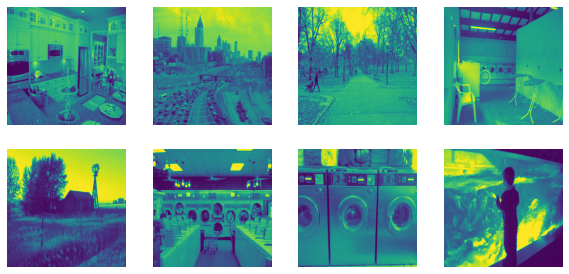

In [ ]:
plt.figure(figsize=(10,10))
for i in range(8):
  plt.subplot(4,4,i+1)
  plt.axis('off')
  plt.imshow(X_[i])

In [ ]:
K.clear_session()
def InstantiateModel(in_):
    #model 1
    model_ = Conv2D(64,(3,3),padding="same",use_bias=True)(in_)
    model_ = ReLU()(model_)
    model_ = Conv2D(64,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    #model 2
    model_ = Conv2D(128,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(128,(3,3),padding="same",strides=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    #model 3
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",strides=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    #model 4
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    #model 5
    model_ = Conv2D(512,(3,3),padding="same",dilation_rate=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",dilation_rate=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",dilation_rate=(2, 2),use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
    
    #model 6
    model_ = Conv2D(512,(3,3),dilation_rate=(2, 2),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),dilation_rate=(2, 2),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),dilation_rate=(2, 2),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)

    #model 7
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(512,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = BatchNormalization()(model_)
        
    #model 8
    model_ = Conv2DTranspose(256,(4,4),padding="same",strides=2,use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)
    model_ = Conv2D(256,(3,3),padding="same",use_bias=True)(model_)
    model_ = ReLU()(model_)

    model_ = Conv2D(313,(1,1),padding='valid',use_bias=True)(model_)
    model_ = Softmax()(model_)
    model_ = Conv2D(2,(1,1),padding='valid')(model_)
    model_ = UpSampling2D((2,2))(model_)
    return model_

In [ ]:
Input_Sample = Input(shape=(HEIGHT, WIDTH,1))
Output_ = InstantiateModel(Input_Sample)

In [ ]:
Model_Colourization = Model(inputs=Input_Sample, outputs=Output_)

In [ ]:
LEARNING_RATE = 0.001
Model_Colourization.compile(optimizer=Adam(lr=LEARNING_RATE),
                            loss='mean_squared_error')
Model_Colourization.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
re_lu (ReLU)                 (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 128)     73856 

In [ ]:
def GenerateInputs(X_,y_):
    for i in range(len(X_)):
        X_input = X_[i].reshape(1,256,256,1)
        y_input = y_[i].reshape(1,256,256,2)
        yield (X_input,y_input)
Model_Colourization.fit(GenerateInputs(X_,y_),epochs=4,verbose=1,steps_per_epoch=10,shuffle=True)

Epoch 1/4
10/10 [==============================] - 190s 19s/step - loss: 17163.5811
Epoch 2/4
10/10 [==============================] - 187s 19s/step - loss: 17497.1023
Epoch 3/4
10/10 [==============================] - 186s 19s/step - loss: 16658.8820
Epoch 4/4
10/10 [==============================] - 188s 19s/step - loss: 17554.8343


In [ ]:
TestImagePath=data[0]
TestImagePath

'../content/Images/sun_afqpfzmhhuegedtn.jpg'

In [ ]:
def ExtractTestInput(ImagePath):
    img = cv2.imread(ImagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_=img_.astype(np.float32)
    img_lab_rs = cv2.resize(img_, (WIDTH, HEIGHT)) # resize image to network input size
    img_l = img_lab_rs[:,:,0] # pull out L channel
    img_l_reshaped = img_l.reshape(1,256,256,1)
    
    return img_l_reshaped


In [ ]:
ImagePath=TestImagePath
# plt.imshow(cv2.imread(ImagePath))
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*110
Prediction=Prediction.reshape(256,256,2)

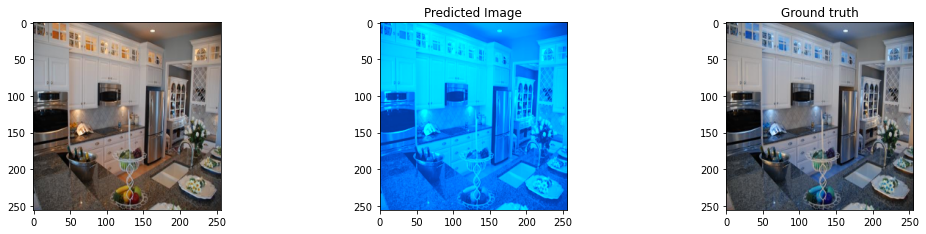

In [ ]:
plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img_1 = cv2.imread(TestImagePath)
img_1 = cv2.resize(img_1, (256, 256))
img = cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
# plt.imshow(img_)
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)

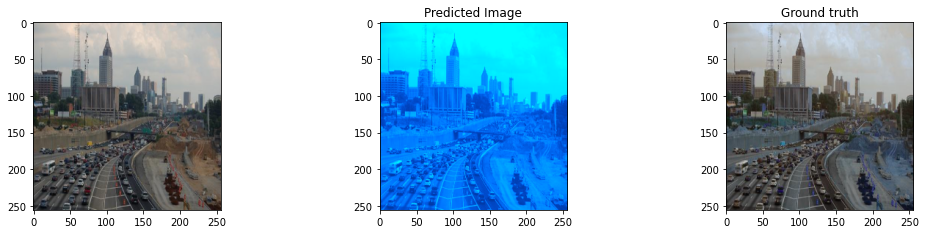

In [ ]:
TestImagePath=data[1]
ImagePath=data[1]
# plt.imshow(cv2.imread(ImagePath))
image_for_test = ExtractTestInput(ImagePath)
Prediction = Model_Colourization.predict(image_for_test)
Prediction = Prediction*110
Prediction=Prediction.reshape(256,256,2)

plt.figure(figsize=(30,20))
plt.subplot(5,5,1)
img_1 = cv2.imread(TestImagePath)
img_1 = cv2.resize(img_1, (256, 256))
img = cv2.cvtColor(img_1,cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (256, 256))
plt.imshow(img)

plt.subplot(5,5,1+1)
img_ = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
img_[:,:,1:] = Prediction
# plt.imshow(img_)
img_ = cv2.cvtColor(img_, cv2.COLOR_Lab2RGB)
plt.title("Predicted Image")
plt.imshow(img_)

plt.subplot(5,5,1+2)
plt.title("Ground truth")
plt.imshow(img_1)